In [4]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py
import PIL
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense,MaxPool2D,Conv2D,Conv2DTranspose,Conv2D,Conv2DTranspose,BatchNormalization,Input,ReLU,Add,Lambda,LeakyReLU,Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow import Tensor
from tensorflow.keras.models import load_model
import tensorflow as tf
from tensorflow.keras.utils import Sequence
import random

from importlib import reload 
from monk import Dataset
   
from PIL import Image 
import PIL 
  


import ncut_loss
import build_Unet
import build_Wnet
import getData

from datasets import get_damaged_generator
from datasets import get_non_damaged_generator
from datasets import get_mixed_generator
import seaborn as sns
import pandas as pd

from getData import get_generator
import tensorflow_addons as tfa

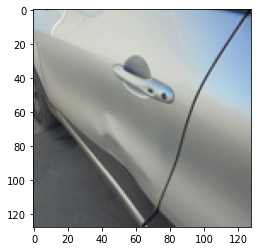

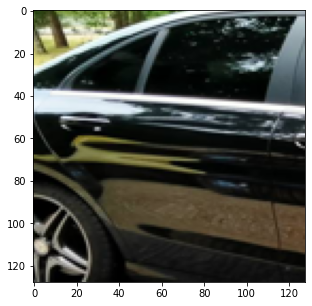

In [10]:
# DATASETS

TRAIN_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_0.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_1.json"]
TEST_DATASET= ["/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_3.json","/shared/perso/nicolas/Projets/Classifieur_idea/idea_data_train/door_batch_4.json"]


damaged_generator = get_generator(TEST_DATASET,10,128,damaged=True)
non_damaged_generator = get_generator(TEST_DATASET,10,128,damaged=False)

dam = damaged_generator.__getitem__(np.random.randint(1,1000))
plt.imshow((dam[0]+1)/2)


no_dam = non_damaged_generator.__getitem__(np.random.randint(1,1000))
plt.figure(figsize=(5,5))
plt.imshow((no_dam[0]+1)/2)

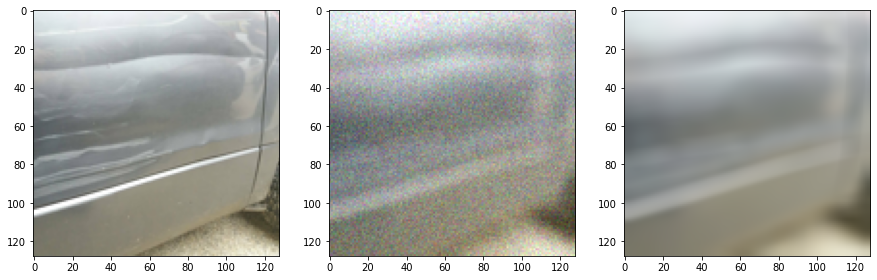

In [11]:
image = damaged_generator.__getitem__(np.random.randint(1,1000))

image_blurred = tfa.image.gaussian_filter2d( image,(10,10),5)


noise = np.random.normal(0, .1, image.shape)

image_o_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)

image_blurred = image_blurred + noise
image_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)


plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow((image[0]+1)/2)
plt.subplot(1,3,2)
plt.imshow((image_blurred[0]+1)/2)
plt.subplot(1,3,3)
plt.imshow((image_o_blurred[0]+1)/2)

(10, 128, 128, 3)


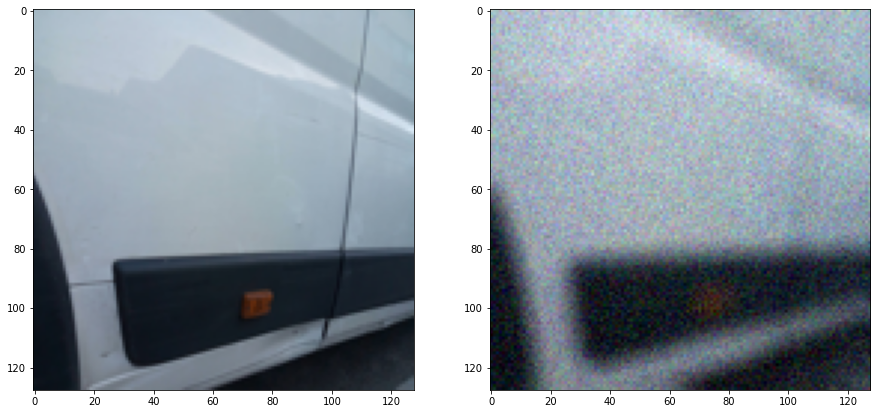

In [13]:
image = damaged_generator.__getitem__(16)

print(image.shape)
sigma=5
blur_kernel=10
noise_amp=0.1

image_blurred = tfa.image.gaussian_filter2d( image,(blur_kernel,blur_kernel),sigma)
noise = np.random.normal(0, noise_amp, image.shape)
image_blurred = image_blurred + noise
image_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)


plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow((image[0]+1)/2)
plt.subplot(1,2,2)
plt.imshow((image_blurred[0]+1)/2)



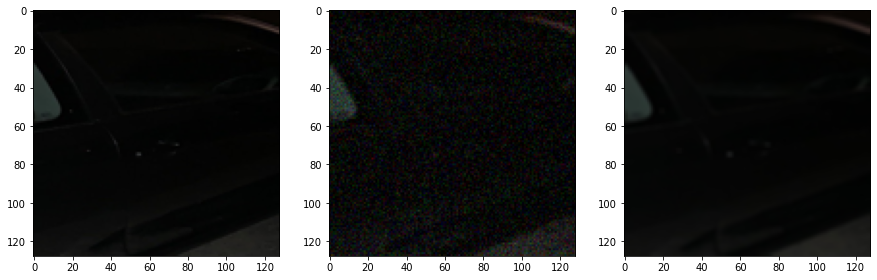

In [9]:
image = non_damaged_generator.__getitem__(3)

image_blurred = tfa.image.gaussian_filter2d( image,(3,3),10)


noise = np.random.normal(0, .1, image.shape)

image_o_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)

image_blurred = image_blurred + noise
image_blurred = tf.clip_by_value(image_blurred, clip_value_min=-1, clip_value_max=1)


plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow((image[0]+1)/2)
plt.subplot(1,3,2)
plt.imshow((image_blurred[0]+1)/2)
plt.subplot(1,3,3)
plt.imshow((image_o_blurred[0]+1)/2)

In [37]:
# MODEL

neighbor_filter=ncut_loss.neighbor_filter((128,128))

#encoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='encoder',input_size=128,use_dropout=False)
#decoder = build_Unet.build_Unet(K=4,stages = [1,2,3,4],filters = 64,type='decoder',input_size=128,use_dropout=False)
#wn = build_Wnet.Wnet(encoder,decoder,(128,128))

K=18
INPUT_DIM=128
USE_DROPOUT=False

encoder = build_Unet.Unet(K=K,type='encoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
decoder = build_Unet.Unet(K=K,type='decoder',input_size=INPUT_DIM,do_dropout=USE_DROPOUT)
wn = build_Wnet.Wnet(encoder,decoder,(INPUT_DIM,INPUT_DIM))


def custom_loss(y_true, y_pred):
    return K.mean(y_true - y_pred)**2

# Compile the model
wn.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003),
    loss_fn_segmentation = ncut_loss.compute_soft_ncuts,
    loss_fn_reconstruction = tf.keras.losses.MeanSquaredError()
)


wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDropoutIdea/ckpt5300")

In [41]:


wn.load_weights("/home/ubuntu/trainings/damages_classification/2021-06-17-Wnet/WnetDropoutIdea/ckpt5300")

In [43]:
wn(image)

<tf.Tensor: shape=(1, 128, 128, 3), dtype=float32, numpy=
array([[[[-0.49425948, -0.33978266, -0.16927664],
         [-0.5650594 , -0.44576073, -0.21889642],
         [-0.61220884, -0.48446873, -0.2222667 ],
         ...,
         [-0.5801576 , -0.5773159 , -0.5449914 ],
         [-0.6030183 , -0.5857737 , -0.55836   ],
         [-0.44131312, -0.4841467 , -0.4688558 ]],

        [[-0.56542194, -0.4069267 , -0.17551398],
         [-0.6371968 , -0.46425313, -0.19732298],
         [-0.67504716, -0.48761043, -0.18117484],
         ...,
         [-0.58043355, -0.5512197 , -0.5367212 ],
         [-0.6629127 , -0.64024186, -0.6192776 ],
         [-0.62410456, -0.6309136 , -0.5927625 ]],

        [[-0.57438946, -0.40326947, -0.18778433],
         [-0.6154555 , -0.43811363, -0.16898754],
         [-0.6451412 , -0.4638565 , -0.15901352],
         ...,
         [-0.5513175 , -0.5269425 , -0.5030329 ],
         [-0.6437542 , -0.6303915 , -0.6021794 ],
         [-0.6383233 , -0.6341945 , -0.6086744

In [52]:
for l in wn.layers[0].layers:
    print(l)
    print(tf.math.reduce_sum(l.losses))
    break

tf.Tensor(0.0, shape=(), dtype=float32)


In [55]:
model = tf.keras.sequential({
 layers: [
   tf.layers.dense({inputShape: [784], units: 32, activation: 'relu'}),
   tf.layers.dense({units: 10, activation: 'softmax'}),
 ]
});


AttributeError: module 'tensorflow.keras' has no attribute 'sequential'

In [69]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(2, activation="relu", name="layer1",kernel_regularizer=tf.keras.regularizers.L1(0.1)),
        tf.keras.layers.Dense(3, activation="relu", name="layer2",kernel_regularizer=tf.keras.regularizers.L1(0.1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(4, name="layer3",kernel_regularizer=tf.keras.regularizers.L1(0.1)),
    ]
)
# Call model on a test input
x = tf.ones((3, 3))
y = model(x)

In [70]:
for layer in model.layers:
    print(layer)
    print(tf.math.reduce_sum(layer.losses))

tf.Tensor(0.16916268, shape=(), dtype=float32)
tf.Tensor(0.34320268, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(0.79453725, shape=(), dtype=float32)


In [72]:
model.layers+model.layers